# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать

Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента. 

Цель - проверить, изменился ли показатель изменения доли успешных сессий (в которых более 4-х просмотров) на статистически значимый параметр.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [62]:
#Импортируем все необходимые библиотеки для дальнейшей работы:

import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats as st

import numpy as np

from statsmodels.stats.proportion import proportions_ztest

In [63]:
df_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')
df_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [64]:
#Для каждого уникального пользователя user_id рассчитаем количество уникальных сессий session_id:

user_sessions = df_history.groupby('user_id')['session_id'].count()

In [65]:
#Найдем пользователя с наибольшим количеством сессий:

user_with_max_sessions = user_sessions.idxmax()

In [66]:
#Выведим на экран все данные из таблицы sessions_history для одного пользователя с наибольшим количеством сессий:

max_user_data = df_history[df_history['user_id'] == user_with_max_sessions]

max_user_data.info()
max_user_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 115558 to 414743
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            10 non-null     object
 1   session_id         10 non-null     object
 2   session_date       10 non-null     object
 3   session_start_ts   10 non-null     object
 4   install_date       10 non-null     object
 5   session_number     10 non-null     int64 
 6   registration_flag  10 non-null     int64 
 7   page_counter       10 non-null     int64 
 8   region             10 non-null     object
 9   device             10 non-null     object
dtypes: int64(3), object(7)
memory usage: 880.0+ bytes


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


У пользователя с максимальным количеством сессий 10 сессий, которые были осуществлены в период с 14 по 25 августа 2025. Сессии осуществлялись практически ежедневно за исключением 21 августа. Пользователь является незарегестрированным. Количество просмотренных страниц во время сессии варьируется от 1 до 4, при чем в начале их было больше, но четкой корреляции на снижение нет. Самые низкие значения просмотренных страниц показаны в середине пользовательского периода клиента. Пользователь из региона СНГ и использует Android. Получается, что пользователь с максимальным количеством сессий незарегестрированный и пользовался приложением лишь в короткий срок в течение 12 дней, а затем перестал пользоваться приложением, и раз он не зарегестрирован, то судя по всему не собирается в приложение возвращаться.

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [67]:
#Рассчитаем число уникальных пользователей для каждого дня наблюдения:

users_by_date = df_history.groupby(['session_date'])['user_id'].count()

In [68]:
#Рассчитаем число зарегистрированных пользователей для каждого дня наблюдения:

reg_users_by_date = df_history.groupby(['session_date'])['registration_flag'].sum()

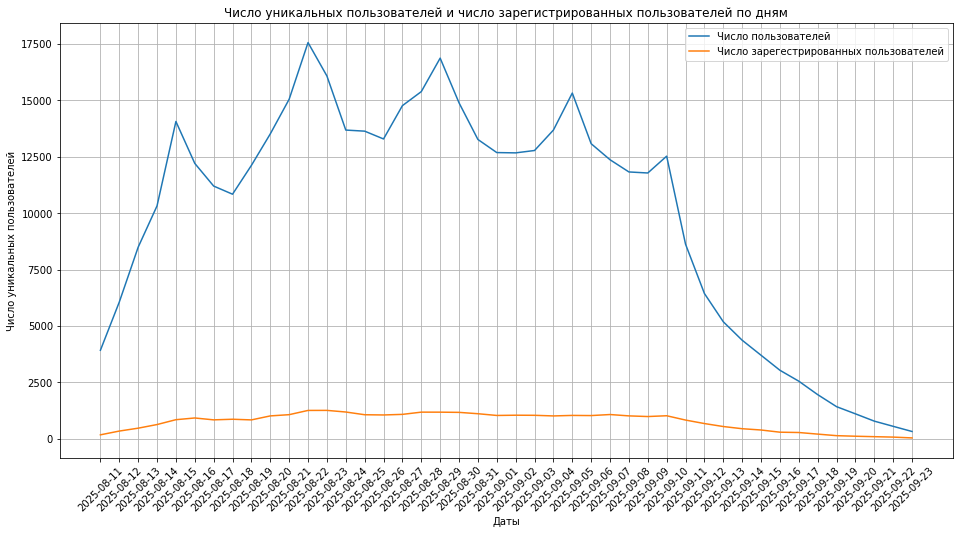

In [69]:
#Построем линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням:
plt.figure(figsize=(16,8))
plt.plot(users_by_date, label = 'Число пользователей')
plt.plot(reg_users_by_date, label = 'Число зарегестрированных пользователей')

plt.title('Число уникальных пользователей и число зарегистрированных пользователей по дням')
plt.ylabel('Число уникальных пользователей')
plt.xlabel('Даты')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

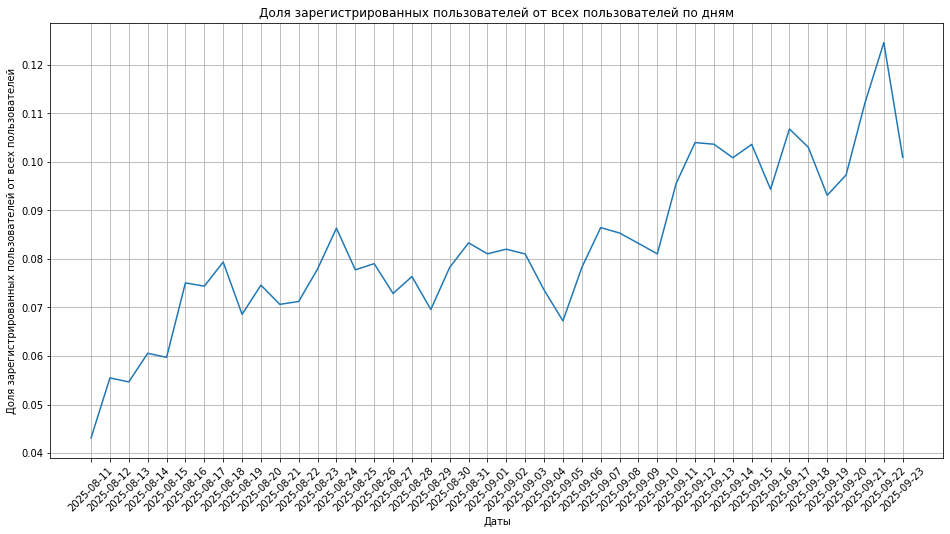

In [70]:
#Построем отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням:

plt.figure(figsize=(16,8))
plt.plot(reg_users_by_date/users_by_date)

plt.title('Доля зарегистрированных пользователей от всех пользователей по дням')
plt.ylabel('Доля зарегистрированных пользователей от всех пользователей')
plt.xlabel('Даты')
plt.xticks(rotation=45)
plt.grid()

Тенденция количества уникальных пользователей и зарегестрированных пользователей по дням схожая. Сначала надается стремительный рост (с 11 по 14 августа), потом - волнообразные скачки (до 10 сентября) и в конце стремительное падение этого числа. Максимальное значение общего числа пользователей - 17500 наблюдается 21 августа. Максимальное число зарегестрированных пользователей примерно в ту же дату - 2300. Минимальное в последний день наблюдений 23 сентября, оно приближается к нулю.

По кривой доли зарегистрированных пользователей от всех пользователей по дням наблюдается в целом положительная динамика с некоторыми скачками. Однако в последний день наблюдений 23 сентября наблюдается заметное снижение от 12,5% до 10%.

Резкое снижение чсила пользователей в последнее время (с 10 сентября) - тревожный сигнал.

Также странно, что данные по наблюдениям собраны с 11 августа по 23 сентября 2025, то есть в будущем. Скорее всего либо ошибка в написании года, либо смоделированы гипотетические данные.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [71]:
#Найдем количество сессий для каждого значения количества просмотренных страниц:

sessions_by_pages = df_history.groupby('page_counter')['session_id'].count()

In [72]:
sessions_by_pages

page_counter
1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: session_id, dtype: int64

Text(0, 0.5, 'Количество сессий')

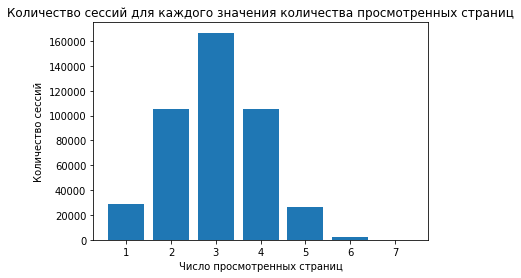

In [73]:
#Построем столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий:

plt.plot(figsize=(16,8))
plt.bar(sessions_by_pages.index, sessions_by_pages.values) 

plt.title('Количество сессий для каждого значения количества просмотренных страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')

Наибольшее количество сессий характерно для трех просмотренных страниц (примерно 167 тыс. сессий), наименьшее - для 7 (92 сессии). В целом тенденцию можно описать следющим образом: чем центрее значение просмотренных страниц, тем выше количество сессий для них. Для одной и пяти страниц количество сессий почти равно. Для 6 и 7 страниц оно крайне мало по сравнению с отсальными значениями.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [74]:
#В датафрейме `sessions_history` создадим дополнительный столбец `good_session:

df_history['good_session'] = (df_history.groupby('session_id')['page_counter'].transform('sum') >= 4).astype(int)

In [75]:
df_history['good_session'] = pd.to_numeric(df_history['good_session'],downcast='integer')

In [76]:
#Создадим датафрейм daily_sessions, где отобразим количество сессий и колиичество успешнных сессий по датам:

daily_sessions = df_history.groupby('session_date').agg(
    total_sessions=('session_id', 'nunique'),
    good_sessions=('good_session', 'sum')
).reset_index()

In [77]:
#Посчитаем рейтинг успеха по дням. Для его отображения создадим столбец sucsess_rate в новом датафрейме:

daily_sessions['sucsess_rate'] = daily_sessions['good_sessions']/daily_sessions['total_sessions']

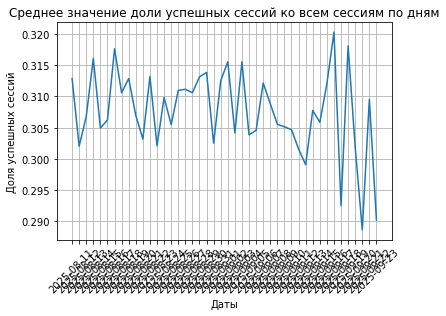

In [78]:
#Построим график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения:

plt.plot(figsize=(16,8))
plt.plot(daily_sessions['session_date'], daily_sessions['sucsess_rate'])

plt.title('Среднее значение доли успешных сессий ко всем сессиям по дням')
plt.ylabel('Доля успешных сессий')
plt.xlabel('Даты')
plt.xticks(rotation=45)
plt.grid()

plt.show()

Среднее значение доли успешных сессий ко всем сессиям по дням имеет волнообразную сруктуру, но имеет тенденцию на снижение в конце периода наблюдения. Наивысшая доля успешных сессий за весь период наблюдениясоставляет 0,32 и характерна для 17 сентября, минимальня - 0,29 - 21 сентября. 

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [79]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [80]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = users_by_date.mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [81]:
#Сохраним в датафрейм sessions_test_part CSV-файл с историческими данными о сессиях пользователей и выведим его первые 5 строк на экран:

sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [82]:
#На его основе создадим датафрейм users_by_group, в котром покажем количество уникальных пользователей в каждой из групп:

users_by_group = sessions_test_part.groupby('test_group').agg(users_count=('user_id', 'nunique')).reset_index()

In [83]:
users_by_group

,test_group,users_count
0,A,1477
1,B,1466


In [84]:
#Выведем количество уникальных пользователей в группах в значениях A и B:

A = users_by_group[users_by_group['test_group'] == 'A']['users_count'].sum()

In [85]:
B = users_by_group[users_by_group['test_group'] == 'B']['users_count'].sum()

In [86]:
#Рассчитаем и выведим на экран процентную разницу в количестве пользователей в группах A и B:

P = 100*((A-B)/A)

In [87]:
P

0.7447528774542992

Text(0, 0.5, 'Группы')

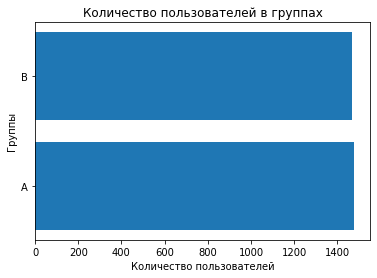

In [88]:
#Построим визуализацию, на которой можно было бы увидеть возможное различие двух групп:

plt.plot(figsize=(16,8))

plt.barh(users_by_group['test_group'], users_by_group['users_count'])

plt.title('Количество пользователей в группах')
plt.xlabel('Количество пользователей')
plt.ylabel('Группы')

Процентная разница составляет менее 1. На графике видно, что разница между двумя группами несущественна.

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [89]:
#Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедимся, что таких нет:

A_user_id = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']

B_user_id = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

intersection = list(set(A_user_id) & set(B_user_id))

intersection

[]

Таких пользователей нет.

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


In [90]:
sessions_test_part.groupby(['device','test_group'])['user_id'].nunique()

device   test_group
Android  A             656
         B             668
Mac      A             156
         B             148
PC       A             369
         B             381
iPhone   A             296
         B             269
Name: user_id, dtype: int64

In [91]:
#Сгруппируем данные по группе А в отдельный датафрейм:

A_group = sessions_test_part[sessions_test_part['test_group']=='A']

In [92]:
#Сохраним данные по количеству пользователей по группе устройств для группы А:

A_device_count = A_group.groupby('device')['user_id'].nunique()

In [93]:
#Сгруппируем данные по группе B в отдельный датафрейм:

B_group = sessions_test_part[sessions_test_part['test_group']=='B']

In [94]:
#Сохраним данные по количеству пользователей по группе устройств для группы B:

B_device_count = B_group.groupby('device')['user_id'].nunique()

Text(0.5, 1.0, 'Распределение устройств для пользователей из группы А')

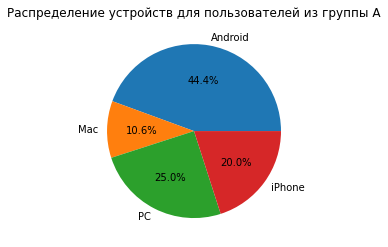

In [95]:
#Построим диаграмму по доле каждого типа устройства для пользователей из группы А:

plt.plot(figsize=(16,8))

plt.pie(A_device_count, labels=A_device_count.index,
    autopct='%1.1f%%'
)

plt.title('Распределение устройств для пользователей из группы А')

Text(0.5, 1.0, 'Распределение устройств для пользователей из группы B')

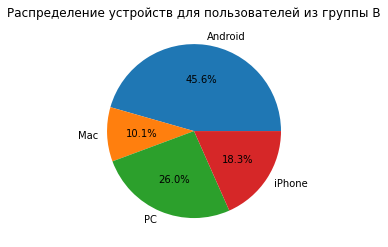

In [96]:
#Построим диаграмму по доле каждого типа устройства для пользователей из группы B:

plt.plot(figsize=(16,8))

plt.pie(B_device_count, labels=B_device_count.index,
    autopct='%1.1f%%'
)

plt.title('Распределение устройств для пользователей из группы B')

В целом распределение устройств для из двух групп схожее.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


In [97]:
#Сохраним данные по количеству пользователей по группе устройств для группы А:

A_region_count = A_group.groupby('region')['user_id'].nunique()

In [98]:
#Сохраним данные по количеству пользователей по группе устройств для группы B:

B_region_count = B_group.groupby('region')['user_id'].nunique()

Text(0.5, 1.0, 'Распределение пользователей по регионам из группы А')

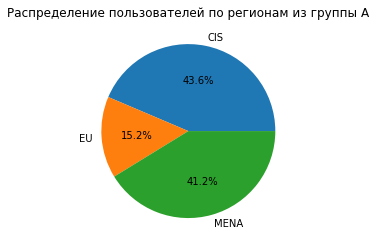

In [99]:
#Построим диаграмму распределения пользователей по регионам из группы А:

plt.plot(figsize=(16,8))

plt.pie(A_region_count, labels=A_region_count.index,
       autopct='%1.1f%%')

plt.title('Распределение пользователей по регионам из группы А')

Text(0.5, 1.0, 'Распределение пользователей по регионам из группы B')

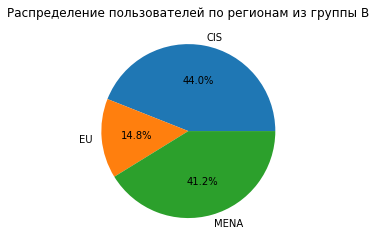

In [100]:
#Построим диаграмму распределения пользователей по регионам из группы B:

plt.plot(figsize=(16,8))

plt.pie(B_region_count, labels=B_region_count.index,
       autopct='%1.1f%%')

plt.title('Распределение пользователей по регионам из группы B')

В целом распределение пользователей по регионам для из двух групп схожее.

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

Между двумя группами ощутимая разница не наблюдается.

Процентная разница между количеством пользователей в двух группах составляет менее 1. Разница между двумя группами несущественна.

Выборки независимы. Не было обнаружено пересечения пользователей из тестовой и контрольной групп.

Сохраняетя равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

A/B-тест проходит корректно. Нарушений не наблюдается.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [101]:
#Сохраним в датафрейм`sessions_test`CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv:

sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [102]:
#В датафрейме sessions_test создадим дополнительный столбец good_session:

sessions_test['good_session'] = (sessions_test.groupby('session_id')['page_counter'].transform('sum') >= 4).astype(int)

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

Перед тестом сформулируем нулевую и альетрнативную гипотезы:
H₀ (нулевая гипотеза) — количество уникальных дневных сессий не различается между тестовой и контрольной группами.
H₁ (альтернативная гипотеза) — количество уникальных дневных сессий различается между тестовой и контрольной группами.

In [103]:
sessions_test_A = sessions_test[sessions_test['test_group'] == 'A']

In [104]:
sessions_test_B = sessions_test[sessions_test['test_group'] == 'B']

In [105]:
sessions_A = sessions_test_A.groupby('session_date')['session_id'].nunique()

In [106]:
sessions_B = sessions_test_B.groupby('session_date')['session_id'].nunique()

In [107]:
alpha = 0.05
results = st.ttest_ind(sessions_A, sessions_B, alternative = 'two-sided')

print('p-значение:', results.pvalue)

if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу.' 
      'Количество уникальных дневных сессий в двух выборках различается, и различия статистически значимы')
else:
    print('Не удалось отвергнуть нулевую гипотезу.' 
      'Количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы')

p-значение: 0.938219304859116
Не удалось отвергнуть нулевую гипотезу.Количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы


p-значение: 0.938219304859116, что сильно выше чем значение alpha.
Это значит, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы.

#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

Выдвинем гипотезу, что нововведение в приложении увеличит долю успешных сессий среди пользователей. Проверим эту гипотезу.

In [108]:
#Создадим датафрейм avg_sessions, где отобразим среднее колиичество успешнных по группам:

avg_sessions = sessions_test.groupby('test_group')['good_session'].mean()

In [109]:
#Посчитаем среднее значение рейтинг успеха по дням для группы A:

rating_sessions_A = avg_sessions.get('A',0)

In [110]:
rating_sessions_A

0.3077233557344958

In [111]:
#Посчитаем среднее значение рейтинг успеха по дням для группы B:

rating_sessions_B = avg_sessions.get('B',0)

In [112]:
rating_sessions_B

0.31828992745867524

In [113]:
#Посчитаем разницу между средними значениями рейтинга двух групп:

rating_sessions_A - rating_sessions_B

-0.010566571724179463

Среднее значение рейтинг успеха по дням для группы A составляет примерно 30,77%, для группы B - 31,83%. Доля успешных сессий в тестовой выборке примерно на 1,1% выше, чем в контрольной.

#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

Перед тестом сформулируем нулевую и альетрнативную гипотезы: H₀ (нулевая гипотеза) — изменение в метрике доли успешных сессий в двух группах не различается или статистически не значимо. H₁ (альтернативная гипотеза) — изменение в метрике доли успешных сессий в двух группах различается или статистически значимо.

Мы сравниваем пропорции (доли успешных сессий).

Поэтому использовать будем Z-тест.

In [114]:
#Посчитаем общее число сессий и количество успешных сессий:

sessions_count = sessions_test.groupby("test_group")["good_session"].count()

In [115]:
good_sessions_count = sessions_test.groupby("test_group")["good_session"].sum()

In [116]:
sessions_count_A = sessions_count.get('A',0)

In [117]:
sessions_count_B = sessions_count.get('B',0)

In [118]:
good_sessions_count_A = good_sessions_count.get('A',0)

In [119]:
good_sessions_count_B = good_sessions_count.get('B',0)

In [120]:
part_A, part_B = good_sessions_count_A/sessions_count_A, good_sessions_count_B/sessions_count_B

In [121]:
# проверим предпосылку о достаточном количестве данных:

if (part_A*sessions_count_A>10)and((1-part_A)*sessions_count_A>10)and(part_B*sessions_count_B>10)and((1-part_B)*sessions_count_B>10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

Предпосылка о достаточном количестве данных выполняется!


In [122]:
# Проведение Z-теста
z_stat, p_value_ztest = proportions_ztest([good_sessions_count_A, good_sessions_count_B],
                                    [sessions_count_A, sessions_count_B],
                                    alternative='two-sided')


print('p-значение:', p_value_ztest)

if p_value_ztest<alpha:
    print('Отвергаем нулевую гипотезу.' 
      'Изменение в метрике доли успешных сессий в двух группах статистически значимо')
else:
    print('Не удалось отвергнуть нулевую гипотезу.' 
      'Изменение в метрике доли успешных сессий в двух группах не различается или статистически не значимо')

p-значение: 0.0003149479976072246
Отвергаем нулевую гипотезу.Изменение в метрике доли успешных сессий в двух группах статистически значимо


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

Характеристики проведённого эксперимента: необходимый размер выборки для каждой группы: 17441, длительность эксперимента: 4 дня. Это допустимый минимальный срок, но с целью повышения надёжности результатов теста желательно провести его дольше — например, на 7 или даже 14 дней, чтобы сгладить возможные колебания в поведении пользователей по дням недели и собрать больше данных для анализа.

Так же следует учитывать, что в последние дни было снижение активности пользователей, поэтому среднее за весь период не будет однозначно характеризовать размер активной аудитории.

Внедрение нового алгоритма рекомендаций на рост ключевой метрики повлияло и повысило его на статистичекси значимую величину. Среднее значение рейтинг успеха по дням для группы A составляет примерно 30,77%, для группы B - 31,83%. Доля успешных сессий в тестовой выборке примерно на 1,1% выше, чем в контрольной.

Значение p-value (0,003) получилось ниже значения alpha. Соответственно, можно отвергнуть нулевую гипотезу.Изменение в метрике доли успешных сессий в двух группах статистически значимо.

Нововведение в приложение внедрять стоит.